<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Linear-Classifier-(MLP-Network)-on-Fashion-MNIST-dataset" data-toc-modified-id="Linear-Classifier-(MLP-Network)-on-Fashion-MNIST-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Classifier (MLP Network) on Fashion MNIST dataset</a></span><ul class="toc-item"><li><span><a href="#Dataset-Download-Commands" data-toc-modified-id="Dataset-Download-Commands-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset Download Commands</a></span></li><li><span><a href="#Function-that-Loads-Dataset" data-toc-modified-id="Function-that-Loads-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Function that Loads Dataset</a></span></li><li><span><a href="#Dataset-Class,-Network-Class,-Train-and-Evaluation-Function" data-toc-modified-id="Dataset-Class,-Network-Class,-Train-and-Evaluation-Function-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Dataset Class, Network Class, Train and Evaluation Function</a></span></li><li><span><a href="#Visualization-of-dataset" data-toc-modified-id="Visualization-of-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Visualization of dataset</a></span></li><li><span><a href="#Basic-Main-Function" data-toc-modified-id="Basic-Main-Function-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Basic Main Function</a></span></li><li><span><a href="#Main-function-with-Cross-Validation" data-toc-modified-id="Main-function-with-Cross-Validation-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Main function with Cross Validation</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Experiments</a></span></li></ul></li></ul></div>

# Linear Classifier (MLP Network) on Fashion MNIST dataset

Elif Cansu YILDIZ

## Dataset Download Commands

In [3]:
# Note: Forwarded stderr to /dev/null so no output will be shown but it works! :)
!wget -O train-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz 2> /dev/null
!wget -O train-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz 2> /dev/null
!wget -O t10k-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz 2> /dev/null
!wget -O t10k-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz 2> /dev/null

In [4]:
# -*- coding: utf-8 -*-
import os
import gzip
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Function that Loads Dataset

In [1]:
def load_mnist(dataset="training", path="."):
    if dataset not in  ['training', 'testing']:
        raise ValueError("dataset has to be either 'training' or 'testing'")

    if dataset == 'training':
        kind = 'train'
    else:
        kind = 't10k'

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8).astype(np.float32)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28).astype(np.float32)

    return th.from_numpy(images), th.from_numpy(labels)

## Dataset Class, Network Class, Train and Evaluation Function

In [2]:
import torch as th

class DatasetFashion():
    def __init__(self, option, classes = range(10), sortd=False, crossvalidation=None, path='./', split_mode=0):
        X,y = load_mnist(option, path)

        self.images = X.reshape([-1, 28*28])
        self.images = self.images/255.0
        self.labels = y.type(th.long) 

        #shuffling
        indices = th.randperm(len(self.labels))
        self.images = self.images[indices]
        self.labels = self.labels[indices]
   
        #eliminating unwanted classes and sorting at the same time
        indices = th.cat([th.nonzero(self.labels == i) for i in classes], dim=0)
        self.images = self.images[indices]
        self.labels = self.labels[indices]

          
        if crossvalidation:
            splitSize = len(self.labels)//crossvalidation[0]
            chunks = th.split(th.arange(len(self.labels)), splitSize, dim=0)
            validation = chunks[crossvalidation[1]]
            training = th.cat([c for j, c in enumerate(chunks) if j!=crossvalidation[1]], dim=0)
            self.validationImages = self.images[validation]
            self.validationLabels = self.labels[validation]
            self.trainingImages = self.images[training]
            self.trainingLabels = self.labels[training]

        else:
            if split_mode==0:

                # shuffle the data before splitting
                indices = th.randperm(len(self.labels))
                self.images = self.images[indices]
                self.labels = self.labels[indices]

                #split the data
                split_ratio = int(len(self.images)*4/5)

                self.trainingImages = self.images[:split_ratio]
                self.trainingLabels = self.labels[:split_ratio]
                self.validationImages = self.images[split_ratio:]
                self.validationLabels = self.labels[split_ratio:]

            else:

                self.trainingImages = th.tensor([])
                self.trainingLabels = th.tensor([], dtype=th.long)
                self.validationImages = th.tensor([])
                self.validationLabels = th.tensor([], dtype=th.long)

                for i in classes:
                    indices = self.labels==i
                    images_i = self.images[indices, :]
                    labels_i = self.labels[indices]
                    split_ratio = int(len(images_i)*4/5)
                    self.trainingImages = th.cat((self.trainingImages, images_i[:split_ratio]), dim=0)
                    self.trainingLabels = th.cat((self.trainingLabels, labels_i[:split_ratio]), dim=0)
                    self.validationImages = th.cat((self.validationImages, images_i[split_ratio:]), dim=0)
                    self.validationLabels = th.cat((self.validationLabels, labels_i[split_ratio:]), dim=0)

        if sortd:
            indices = th.argsort(self.trainingLabels.squeeze())
            self.trainingImages = self.trainingImages[indices]
            self.trainingLabels = self.trainingLabels[indices]


    def __len__(self):
        return len(self.trainingLabels)

    def __getitem__(self, index):
        return self.trainingImages[index], self.trainingLabels[index]
            
class Network(th.nn.Module):
    def __init__(self, num_inputs, num_classes, num_neurons=(50,20), activation=th.relu):
        super(Network, self).__init__()
        self.activation = activation
        self.logsoftmax = th.nn.LogSoftmax(dim=1)
        
        self.layers = th.nn.ModuleList()
        self.layers.append(th.nn.Linear(num_inputs, num_neurons[0], True))
        for i in range(len(num_neurons)-1):
            self.layers.append(th.nn.Linear(num_neurons[i], num_neurons[i+1], True))
        self.layers.append(th.nn.Linear(num_neurons[-1], num_classes, True))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.logsoftmax(self.layers[-1](x))
    
def train(model, dataloader, optimizer):
    
    loss_hist = np.array([])
    for index, (trainingImages,trainingLabels) in enumerate(dataloader):
        optimizer.zero_grad()
        prediction = model(trainingImages.squeeze())
        loss = th.nn.functional.nll_loss(prediction, trainingLabels.squeeze())
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()
        with th.no_grad():
            if index % 100 == 0:
                print('Train {}/{} Loss {:.6f}'.format(index, len(dataloader), loss.item()))
    return loss_hist
                
def evaluate(model, images, labels):
    prediction = model(images.squeeze())
    loss = th.nn.functional.nll_loss(prediction, labels.squeeze())
    pred_label = th.argmax(prediction, dim=1)
    #print("----------", pred_label[00:10], labels.squeeze()[00:10], pred_label[00:10] == labels.squeeze()[00:10])
    accuracy = ((pred_label == labels.squeeze()).sum().item()) / len(images)
    #accuracy = th.sum(pred_label == labels.squeeze()) / len(labels)
    return loss, accuracy


# x * sigmoid(beta*x)
class Swish(th.nn.Module):
    def __init__(self, beta):
        #th.nn.Parameter
        self.beta = th.tensor([beta])
        
    def forward(self, x):
        return x * th.sigmoid(self.beta*x)

## Visualization of dataset

images.shape: torch.Size([1, 1, 784])
images.shape: torch.Size([1, 1, 784])
images.shape: torch.Size([1, 1, 784])
images.shape: torch.Size([1, 1, 784])


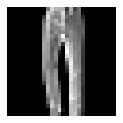

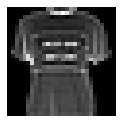

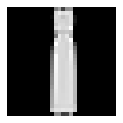

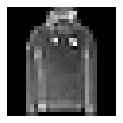

In [32]:
dataset = DatasetFashion("training")
dataloader = th.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

for index, (images, labels) in enumerate(dataloader):
    print('images.shape:', images.shape)
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(images.reshape(28, 28), cmap='gray')
    if index == 3:  #number of batches to visualize
      break

## Basic Main Function

In [ ]:
if __name__ == "__main__":
    
    model = Network(28*28, 10)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
    
    dataset = DatasetFashion("training", sortd=False)
    dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    for epoch in range(10):
        print("Epoch ", epoch)
        train(model, dataloader, optimizer)

## Main function with Cross Validation

In [ ]:
if __name__ == "__main__":
    
    model = Network(28*28, 10, activation = th.sigmoid)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
    
    avgLoss = 0.0
    for i in range(5):
        dataset = DatasetFashion("training", crossvalidation=(5,i))
        dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        for epoch in range(10):
            train(model, dataloader, optimizer)
        avgLoss += evaluate(model, dataset.validationImages, dataset.validationLabels)/5
        
    print("Avg Loss", avgLoss)

## Experiments

Implementing and comparing the following approaches:

a) Train the classes separately, i.e. filter the dataset and train for five epochs on all images depicting a 0, then on all images depicting a 1, and so on.

In [ ]:
if __name__ == "__main__":
    
    model = Network(28*28, 10)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
 
    total_loss = 0
    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])

    for i in range(10):
        dataset = DatasetFashion("training", classes=[i], sortd=False) 
        dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        
        for epoch in range(10):
            print("Epoch ", epoch)
            #training
            loss_hist_per_epoch = train(model, dataloader, optimizer)

            #evaluation
            valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)

            #loss and accuracy histories are kept
            training_loss_hist = np.hstack((training_loss_hist, loss_hist_per_epoch))
            valid_loss_hist = np.hstack((valid_loss_hist, valid_loss.item()))   #item is used to get just number instead of tensor. Otherwise, it raises error
            valid_acc_hist = np.hstack((valid_acc_hist, valid_accuracy))
            print("validation loss = ", valid_loss.item(), " accuracy = ", valid_accuracy)
            total_loss += valid_loss.item()
            
    print("Total loss = ", total_loss)

Text(0.5, 1.0, 'validation accuracy history')

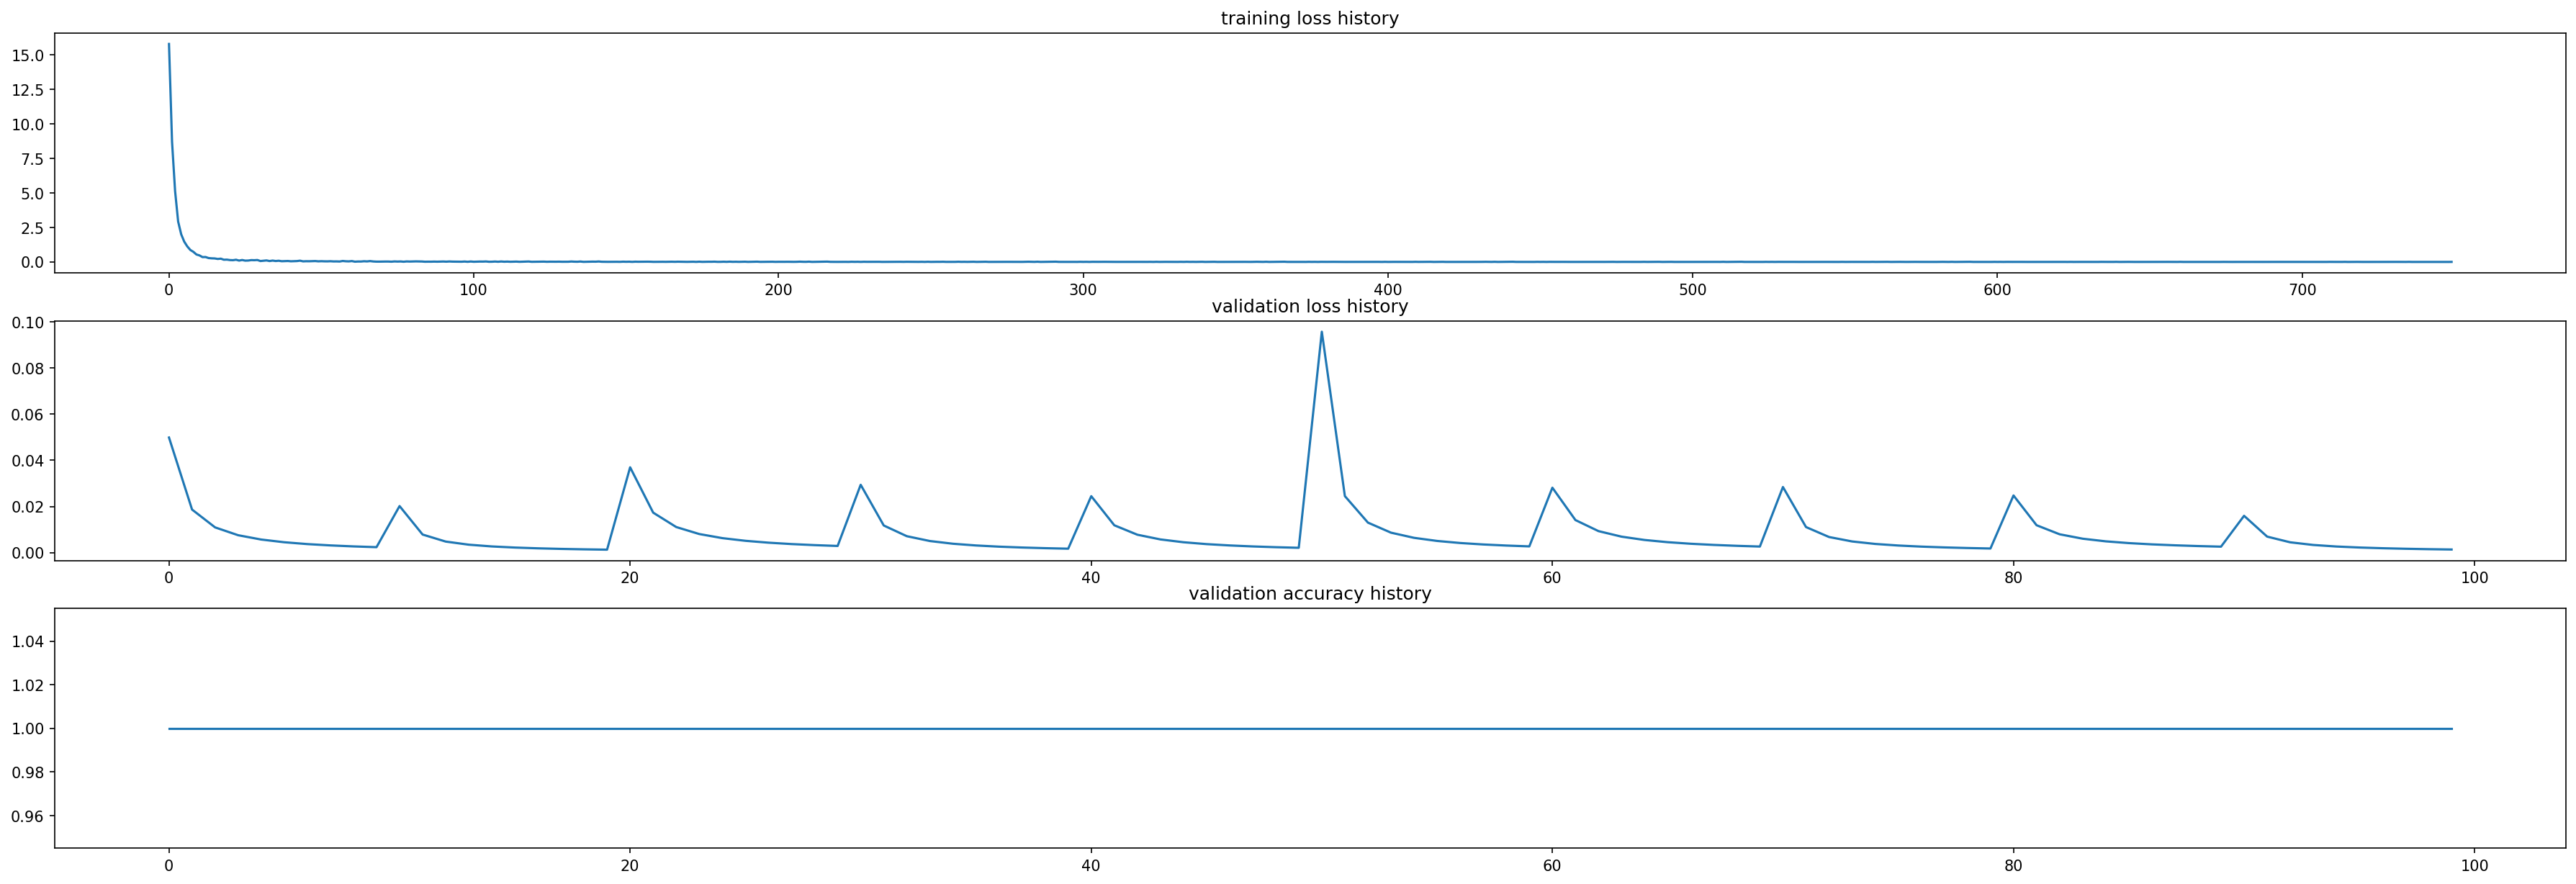

In [177]:
fig, axs = plt.subplots(3, figsize=(30,10), dpi=150, sharex=False, sharey=False)

epoch = 2   #which epoch loss data you want to visualize
num_of_batch = 750
axs[0].plot(training_loss_hist[epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[0].set_title('training loss history')
axs[1].plot(valid_loss_hist); axs[1].set_title('validation loss history')
axs[2].plot(valid_acc_hist); axs[2].set_title('validation accuracy history')

b) Sort the images by class and train them in order for 25 epochs. Make sure that the DataLoader is not shuffling the data.

In [162]:
if __name__ == "__main__":
    
    model = Network(28*28, 10)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
 
    dataset = DatasetFashion("training", sortd=True, split_mode=1) 
    dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    
    total_loss = 0
    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])
    for epoch in range(25):
        print("Epoch ", epoch)
        loss_hist_per_epoch = train(model, dataloader, optimizer)
        
        #loss and accuracy histories are kept
        training_loss_hist = np.hstack((training_loss_hist, loss_hist_per_epoch))
        valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
        valid_loss_hist = np.hstack((valid_loss_hist, valid_loss.item()))   #item is used to get just number instead of tensor. Otherwise, it raises error
        valid_acc_hist = np.hstack((valid_acc_hist, valid_accuracy))
        print("validation loss = ", valid_loss.item(), " accuracy = ", valid_accuracy)
        total_loss += valid_loss

    print("Total loss = ", total_loss.item())

Epoch  0
Train 0/750 Loss 2.318282
Train 100/750 Loss 0.231174
Train 200/750 Loss 0.092376
Train 300/750 Loss 12.166449
Train 400/750 Loss 1.306025
Train 500/750 Loss 0.078490
Train 600/750 Loss 12.945505
Train 700/750 Loss 0.159918
validation loss =  6.075072288513184  accuracy =  0.1
Epoch  1
Train 0/750 Loss 8.775920
Train 100/750 Loss 0.096417
Train 200/750 Loss 0.075041
Train 300/750 Loss 10.682033
Train 400/750 Loss 0.531828
Train 500/750 Loss 0.063007
Train 600/750 Loss 9.902685
Train 700/750 Loss 0.096039
validation loss =  4.473014831542969  accuracy =  0.10033333333333333
Epoch  2
Train 0/750 Loss 6.734507
Train 100/750 Loss 0.080543
Train 200/750 Loss 0.062792
Train 300/750 Loss 7.821257
Train 400/750 Loss 0.207026
Train 500/750 Loss 0.049198
Train 600/750 Loss 7.593697
Train 700/750 Loss 0.102348
validation loss =  3.9189369678497314  accuracy =  0.10791666666666666
Epoch  3
Train 0/750 Loss 5.201716
Train 100/750 Loss 0.054429
Train 200/750 Loss 0.047741
Train 300/750 Loss

Text(0.5, 1.0, 'validation accuracy history')

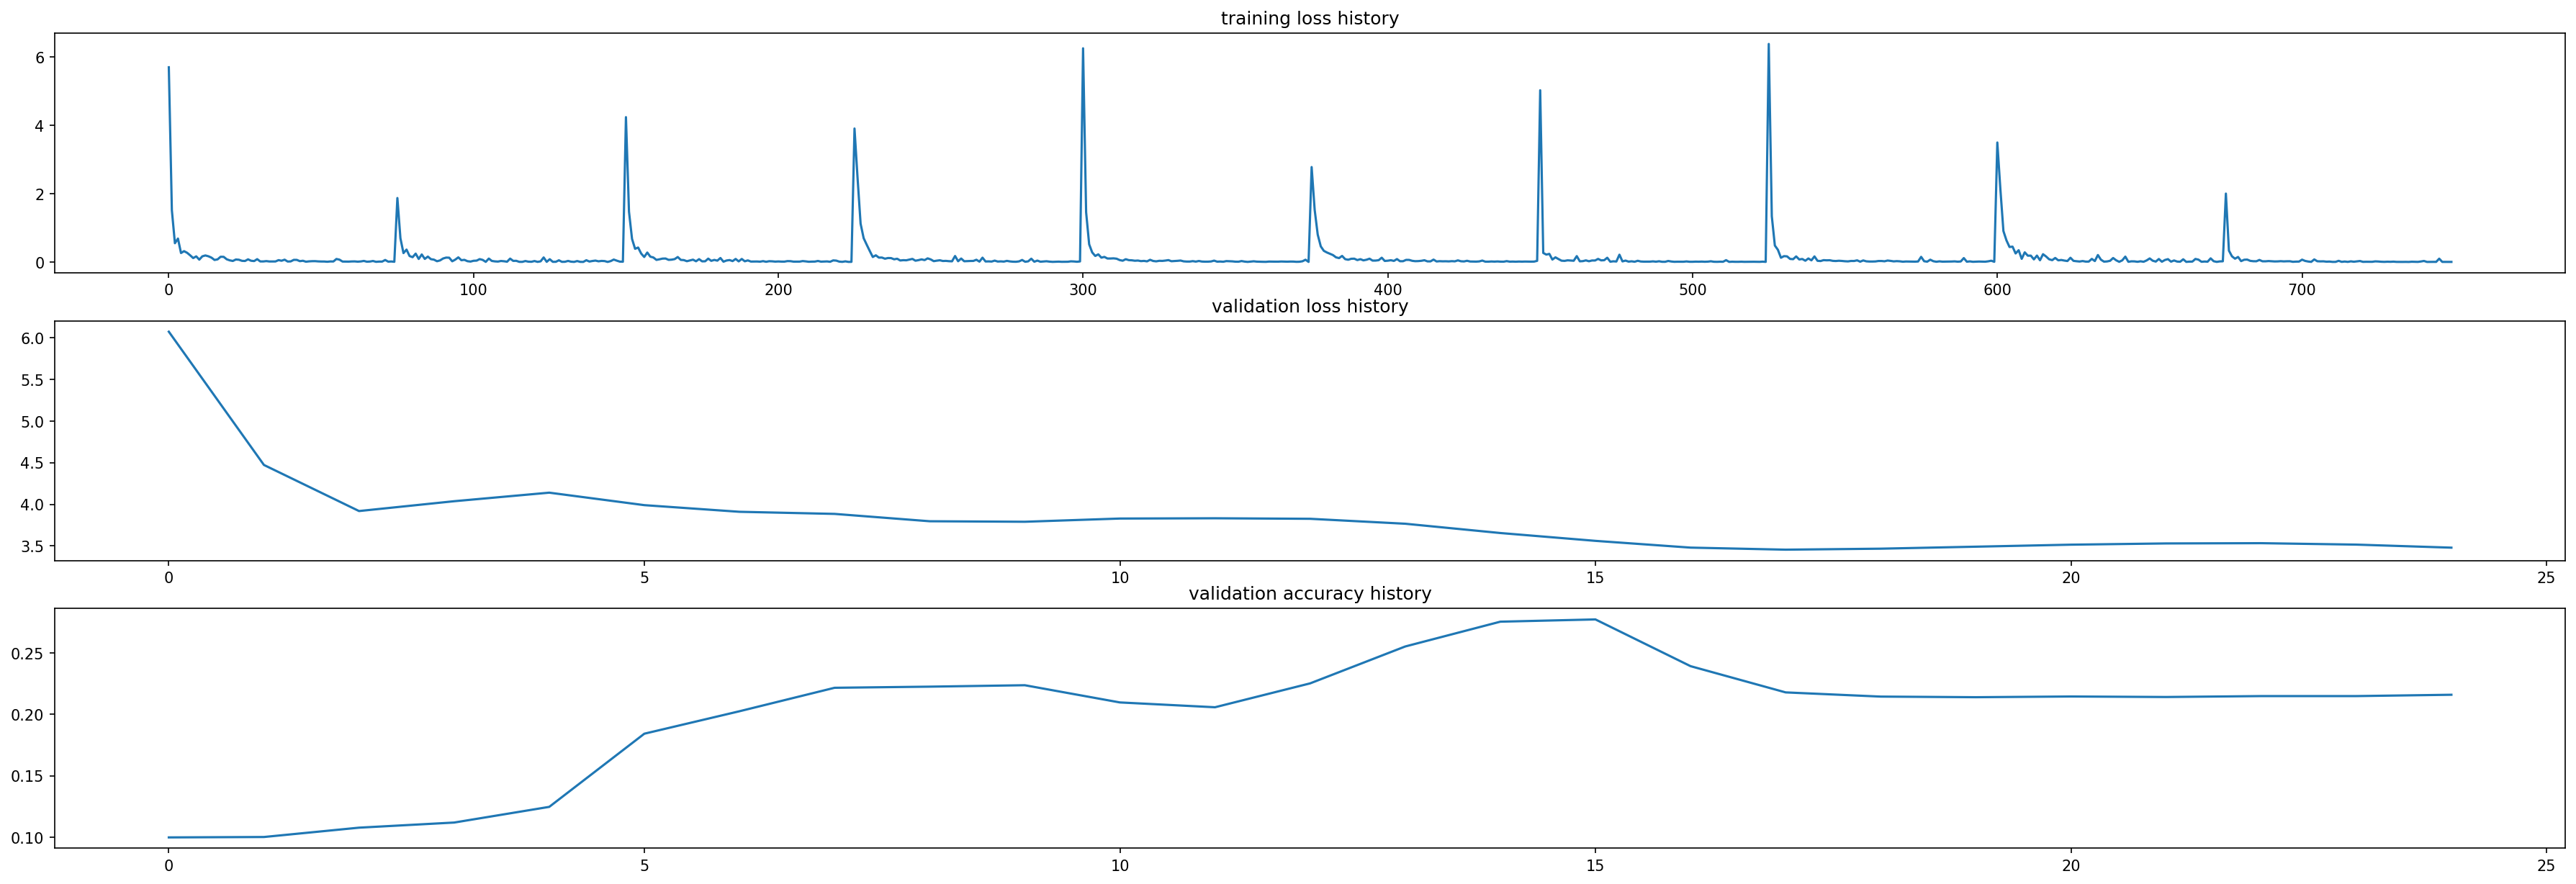

In [163]:
fig, axs = plt.subplots(3, figsize=(30,10), dpi=150, sharex=False, sharey=False)

epoch = 10   #which epoch loss data you want to visualize
num_of_batch = 750
axs[0].plot(training_loss_hist[epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[0].set_title('training loss history')
axs[1].plot(valid_loss_hist); axs[1].set_title('validation loss history')
axs[2].plot(valid_acc_hist); axs[2].set_title('validation accuracy history')

In [ ]:
"""
fig = plt.figure(figsize=(30,6))
ax = fig.add_subplot(1, 1, 1)
epoch = 10   #which epoch loss data you want to visualize
_= ax.plot(training_loss_hist[epoch*750:(epoch+1)*750], "-")
"""

c) Shuffle the images every epoch and train them for 25 epochs.

In [146]:
if __name__ == "__main__":
    
    model = Network(28*28, 10)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
 
    dataset = DatasetFashion("training") 
    dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    
    total_loss = 0
    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])
    for epoch in range(25):
        print("Epoch ", epoch)
        loss_hist_per_epoch = train(model, dataloader, optimizer)
        #loss and accuracy histories are kept
        training_loss_hist = np.hstack((training_loss_hist, loss_hist_per_epoch))
        valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
        valid_loss_hist = np.hstack((valid_loss_hist, valid_loss.item()))   #item is used to get just number instead of tensor. Otherwise, it raises error
        valid_acc_hist = np.hstack((valid_acc_hist, valid_accuracy))
        print("validation loss = ", valid_loss.item(), " accuracy = ", valid_accuracy)
        total_loss += valid_loss

    print("Total loss = ", total_loss)

Epoch  0
Train 0/750 Loss 2.277861
Train 100/750 Loss 2.186685
Train 200/750 Loss 2.009336
Train 300/750 Loss 1.670928
Train 400/750 Loss 1.431317
Train 500/750 Loss 1.313665
Train 600/750 Loss 1.062561
Train 700/750 Loss 1.009581
validation loss =  0.9906061291694641  accuracy =  0.6393333333333333
Epoch  1
Train 0/750 Loss 1.000956
Train 100/750 Loss 0.916453
Train 200/750 Loss 0.979410
Train 300/750 Loss 0.837253
Train 400/750 Loss 0.779358
Train 500/750 Loss 0.933494
Train 600/750 Loss 0.881799
Train 700/750 Loss 0.935348
validation loss =  0.7542577981948853  accuracy =  0.71425
Epoch  2
Train 0/750 Loss 0.864355
Train 100/750 Loss 0.641591
Train 200/750 Loss 0.865113
Train 300/750 Loss 0.781708
Train 400/750 Loss 0.736172
Train 500/750 Loss 0.610212
Train 600/750 Loss 0.618089
Train 700/750 Loss 0.712953
validation loss =  0.6565836071968079  accuracy =  0.77
Epoch  3
Train 0/750 Loss 0.948602
Train 100/750 Loss 0.921899
Train 200/750 Loss 0.596337
Train 300/750 Loss 0.694044
Tra

Text(0.5, 1.0, 'validation accuracy history')

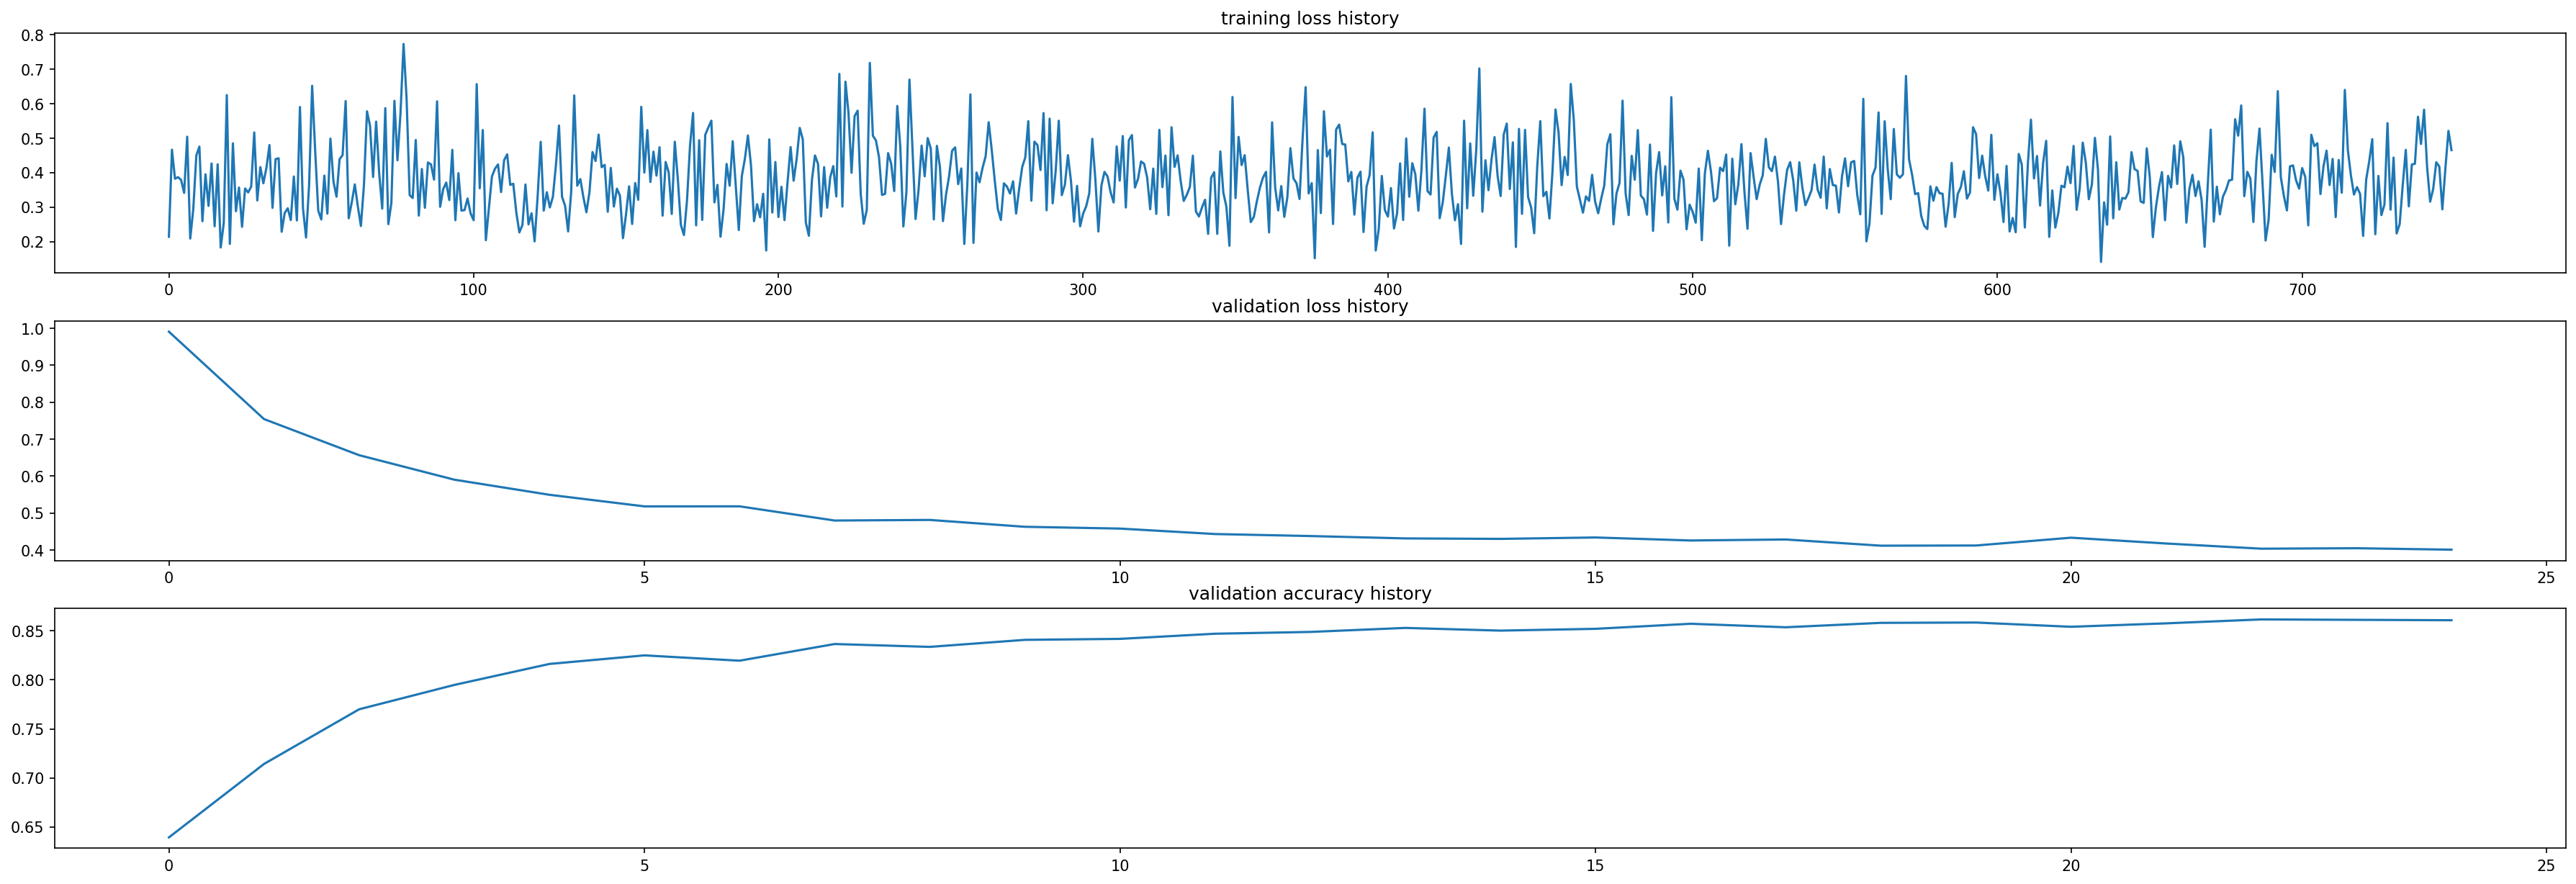

In [160]:
fig, axs = plt.subplots(3, figsize=(30,10), dpi=150, sharex=False, sharey=False)

epoch = 10   #which epoch loss data you want to visualize
num_of_batch = 750
axs[0].plot(training_loss_hist[epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[0].set_title('training loss history')
axs[1].plot(valid_loss_hist); axs[1].set_title('validation loss history')
axs[2].plot(valid_acc_hist); axs[2].set_title('validation accuracy history')


Training using bigger batches (closer to batch gradient descent). Thus, it can be observed that less deviation occurs on the training loss, but it takes more time (more epoch) to reach the similar accuracy (%86) on validation data.

In [170]:
if __name__ == "__main__":
    
    model = Network(28*28, 10)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)
 
    dataset = DatasetFashion("training") 
    dataloader = th.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    
    total_loss = 0
    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])
    for epoch in range(250):
        print("Epoch ", epoch)
        loss_hist_per_epoch = train(model, dataloader, optimizer)
        #loss and accuracy histories are kept
        training_loss_hist = np.hstack((training_loss_hist, loss_hist_per_epoch))
        valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
        valid_loss_hist = np.hstack((valid_loss_hist, valid_loss.item()))   #item is used to get just number instead of tensor. Otherwise, it raises error
        valid_acc_hist = np.hstack((valid_acc_hist, valid_accuracy))
        print("validation loss = ", valid_loss.item(), " accuracy = ", valid_accuracy)
        total_loss += valid_loss

    print("Total loss = ", total_loss)



Epoch  0
Train 0/47 Loss 2.308981
validation loss =  2.281379222869873  accuracy =  0.18475
Epoch  1
Train 0/47 Loss 2.283562
validation loss =  2.248460054397583  accuracy =  0.20325
Epoch  2
Train 0/47 Loss 2.246624
validation loss =  2.2030394077301025  accuracy =  0.20666666666666667
Epoch  3
Train 0/47 Loss 2.198232
validation loss =  2.1404812335968018  accuracy =  0.21425
Epoch  4
Train 0/47 Loss 2.143754
validation loss =  2.0535547733306885  accuracy =  0.24325
Epoch  5
Train 0/47 Loss 2.065785
validation loss =  1.9377307891845703  accuracy =  0.4230833333333333
Epoch  6
Train 0/47 Loss 1.924210
validation loss =  1.7974721193313599  accuracy =  0.4915
Epoch  7
Train 0/47 Loss 1.792879
validation loss =  1.653338074684143  accuracy =  0.51775
Epoch  8
Train 0/47 Loss 1.676931
validation loss =  1.5218987464904785  accuracy =  0.5676666666666667
Epoch  9
Train 0/47 Loss 1.513505
validation loss =  1.4094973802566528  accuracy =  0.5963333333333334
Epoch  10
Train 0/47 Loss 1.4

Text(0.5, 1.0, 'validation accuracy history')

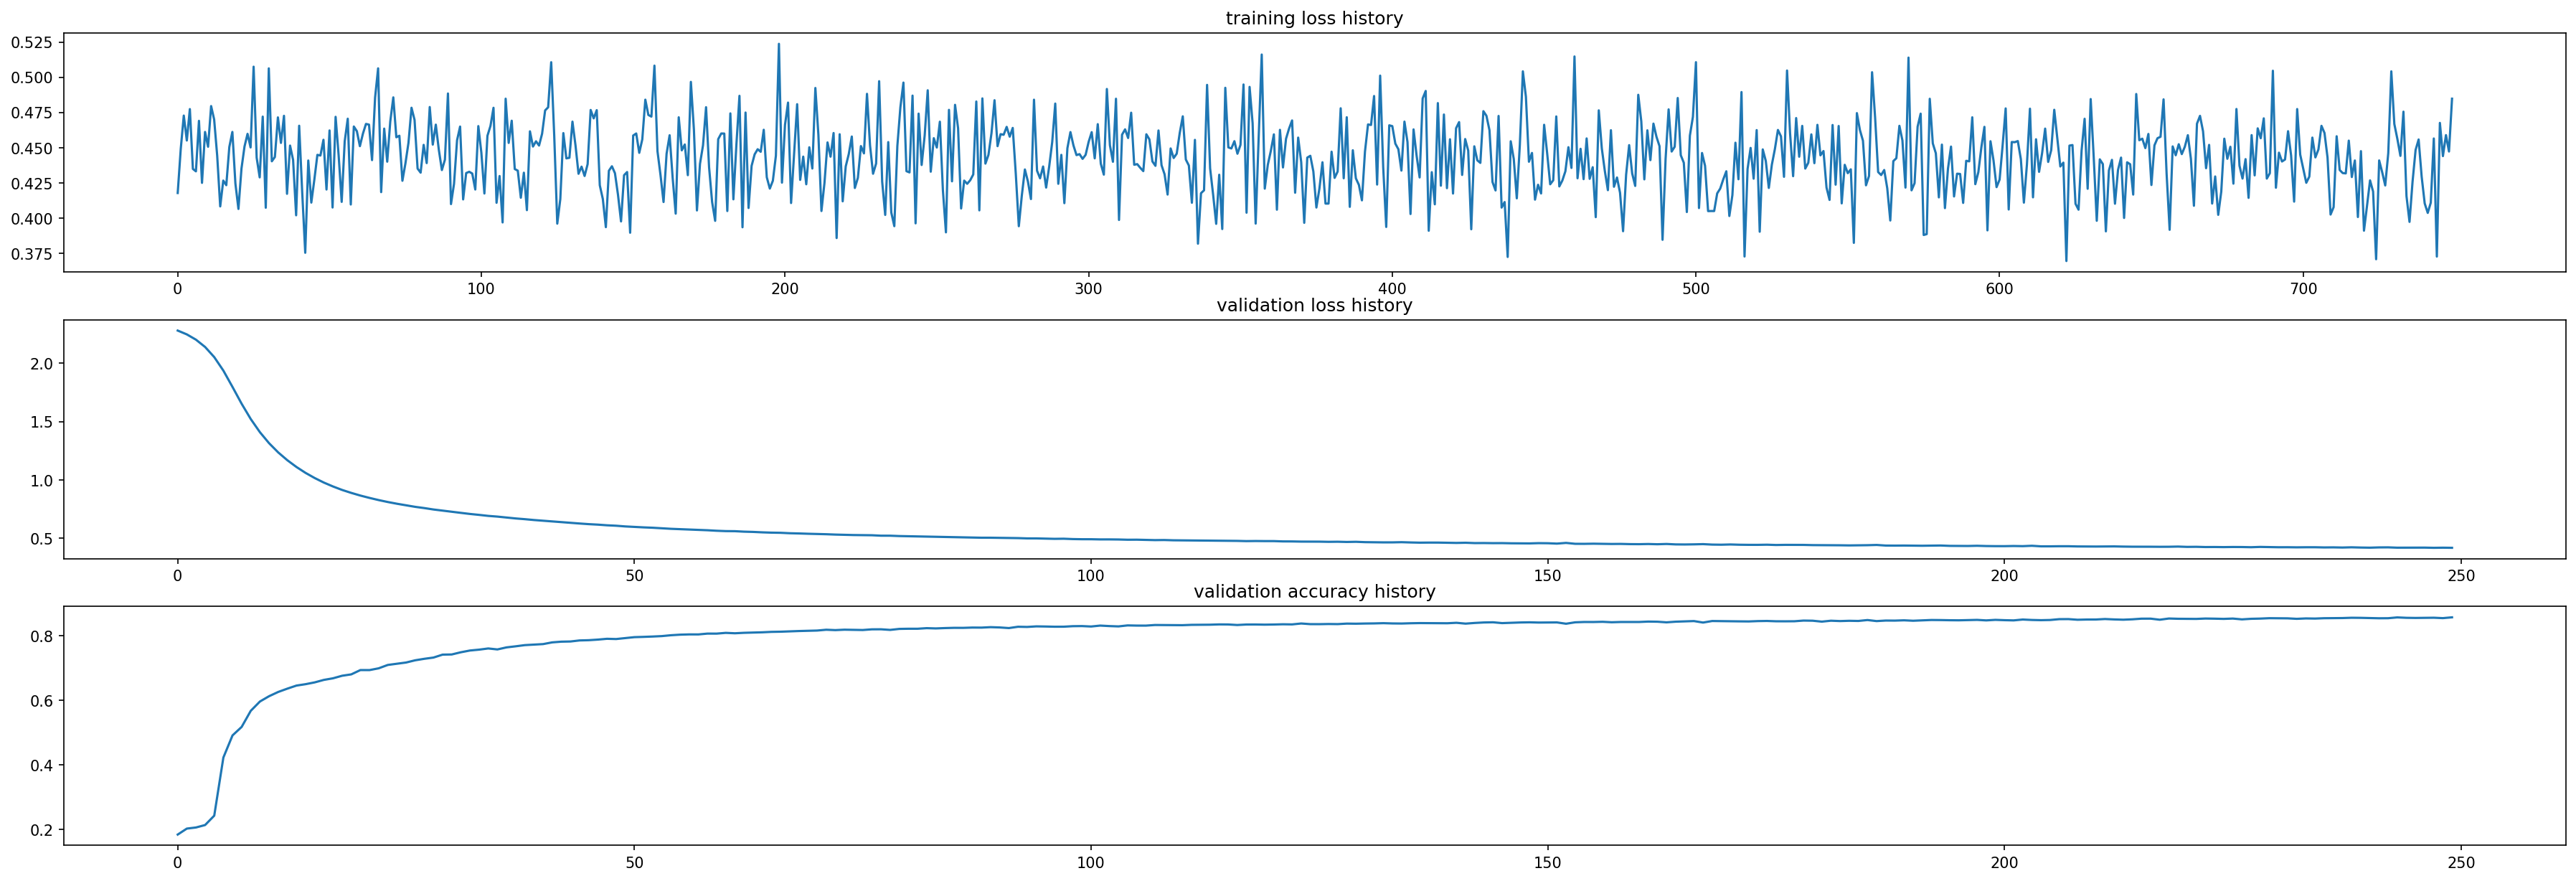

In [172]:
fig, axs = plt.subplots(3, figsize=(30,10), dpi=150, sharex=False, sharey=False)

epoch = 10   #which epoch loss data you want to visualize
num_of_batch = 750
axs[0].plot(training_loss_hist[epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[0].set_title('training loss history')
axs[1].plot(valid_loss_hist); axs[1].set_title('validation loss history')
axs[2].plot(valid_acc_hist); axs[2].set_title('validation accuracy history')